# Julian Lapenna Acoustics Lab

Sept 19, 16:20

Logged on. I don't see a `BareBonesDAQ.m` file... Maybe a python file has replaced it

In [69]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [70]:
from scipy.io import wavfile
samplerate, data = wavfile.read('../data/resonant.wav')
print(data.shape)
print ("Frequency sampling:", samplerate)

(480000, 2)
Frequency sampling: 96000


In [71]:
print(len(data)/samplerate) # time sampled for

5.0


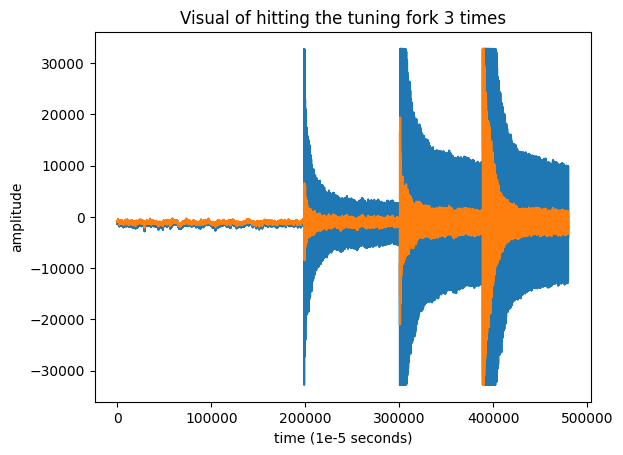

In [72]:
plt.plot(data)
plt.title('Visual of hitting the tuning fork 3 times')
plt.xlabel('time (1e-5 seconds)')
plt.ylabel('amplitude');

In [73]:
print(data[200000]) # looks about right with graph above

[8412  116]


File naming convention (for future):

pXXXX-fXXX-aXX-tXX-X.wav = p\<position\>-f\<frequency\>-a\<amplitude\>-t\<time\>-\<close\far\>.wav

where 
* position = number of steps of the stepper motor and tells me the angle I should be observing
* frequency = 365 Hz the fundamental frequency
* amplitude = the amplitude the motor is set to, for now probably 5
* time = how long the motor goes for, for now probably 5 seconds
* c/f = for movable mic, is it close (~1-3cm) or far (~20-50cm) away

In [74]:
data1 = []

for d in data:
    data1.append(d[0])

print(len(data1))

480000


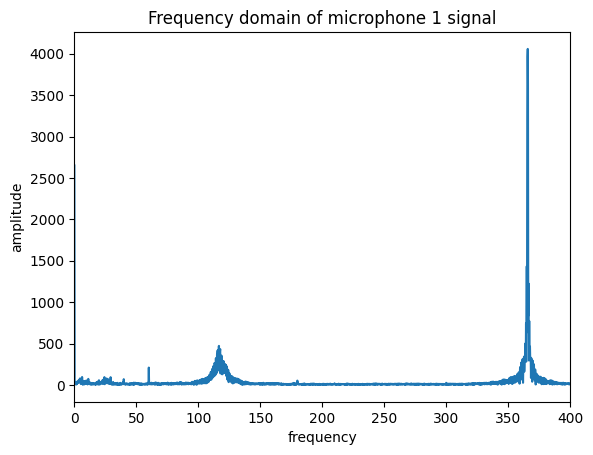

In [75]:
# finding the resonant frequency
from scipy.fft import fft, fftfreq
N = 480000 # sample points
T = 1 / samplerate

yf = fft(data1)
xf = fftfreq(N, T)[:N//2]

# why I divide by N: 
# https://electronics.stackexchange.com/questions/25900/scaling-fft-output-by-number-of-points-in-fft
# summary: there are N samples of each component of the signal that scale with N
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('Frequency domain of microphone 1 signal')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim([0,400])
plt.show()

In [76]:
print("resonant frequency:", xf[np.argmax(yf)], "Hz")

resonant frequency: 365.20000000000005 Hz


So the resonant frequency of the tuning fork is 365 Hz! Great :)

Sept 25, 15:25

Plan, get data from the close field, again in a 90deg sweep since the tuning fork is symmetric, then analyse the data later.

Issue that came up: The stepper motor that is used to position the mic at different positions was broken, so I took a protractor and switched to measuring the angle by hand. This will be a source of error, but I am hoping the data will still show the appropriate trends.

In [45]:
def show_audio_file(filename):
    samplerate, data = wavfile.read(filename)
    print(data.shape)
    print ("Frequency sampling:", samplerate)
    plt.plot(data)

def show_freqs_audio_file(filename):
    samplerate, data = wavfile.read(filename)

    data1 = []

    for d in data:
        data1.append(d[1]) # getting mic 2, the one that moves

    N = len(data1) # sample points
    T = len(data) / samplerate

    yf = fft(data1)
    xf = fftfreq(N, T)[:N//2]

    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.title('frequency domain of signal')
    plt.xlabel('frequency')
    plt.ylabel('amplitude')
    plt.xlim([0,600])
    plt.show()



(192000, 2)
192000
-1124
-1103
-1098
-1083
-1080
-1076
-1070
-1065
-1069
-1078
192000 2.0


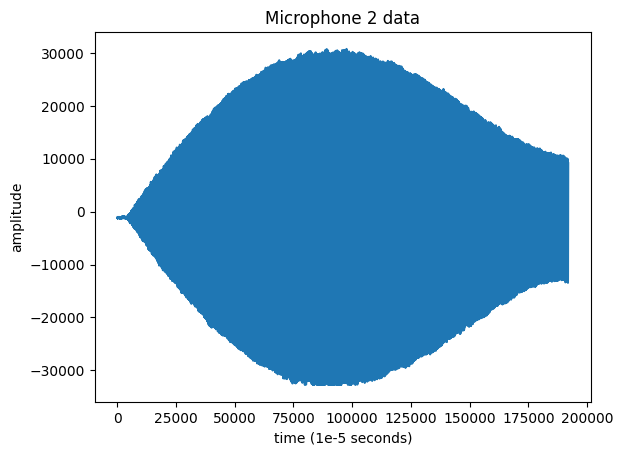

In [48]:
filename = '../data/deg05-f365-a05-t02-c.wav'
# show_audio_file(filename)
# show_freqs_audio_file(filename)

samplerate, data = wavfile.read(filename)

data1 = []

for d in data:
    data1.append(d[1]) # getting mic 2, the one that moves

plt.plot(data1)
plt.title('Microphone 2 data')
plt.ylabel('amplitude')
plt.xlabel('time (1e-5 seconds)')
print(data.shape)
print(len(data1))

for i in range(10):
    print(data1[i])

N = len(data1) # sample points
T = len(data) / samplerate

print(N,T)

# yf = fft(data1)
# xf = fftfreq(N, T)[:N//2]

# plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.title('frequency domain of signal')
# plt.xlabel('frequency')
# plt.ylabel('amplitude')
# plt.xlim([0,600])
# plt.show()

Sept 26, 15:35

Hold on, I don't even need to take the fourier transform, I'm looking at amplitude. So maybe let's look at some of the graphs of the far and close field at the expect minimums.

Close field 45deg, far field 90deg. Additionally, r for close = 1cm, while r for far = 20cm.

(192000, 2)
Frequency sampling: 96000


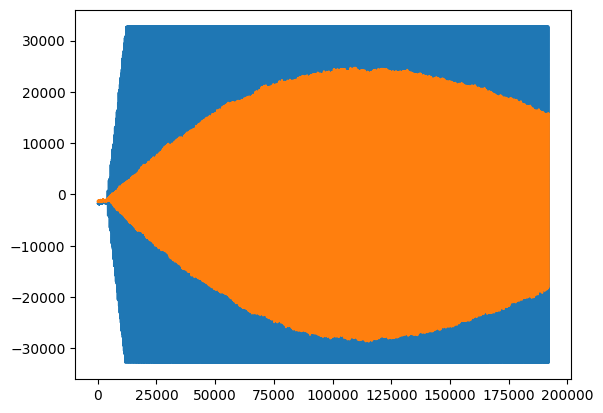

In [19]:
filename = '../data/deg45-f365-a05-t02-c.wav'
show_audio_file(filename)

32767
(192000, 2)
Frequency sampling: 96000


Text(0.5, 0, 'time (1e-5 seconds)')

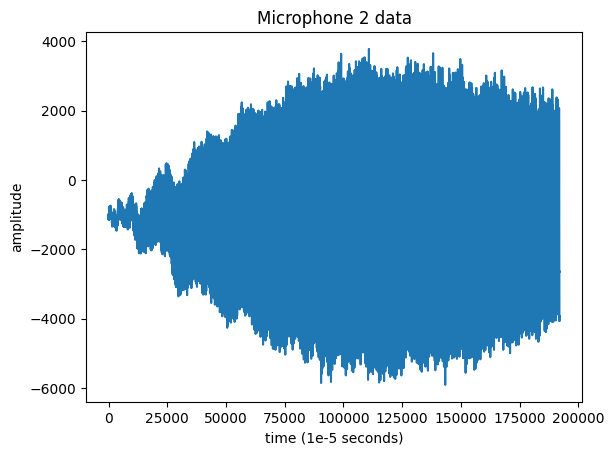

In [51]:
print(np.max(data))

filename = '../data/deg70-f365-a05-t02-c.wav'
samplerate, data = wavfile.read(filename)
print(data.shape)
print ("Frequency sampling:", samplerate)

plt.plot([subdata[1] for subdata in data])
plt.title('Microphone 2 data')
plt.ylabel('amplitude')
plt.xlabel('time (1e-5 seconds)')

# plt.ylim([-4e4, 4e4])

Ahhhh, so after increasing the bounds, the top and bottom are chopped, likely the mic is saturated, I will have to take data at a lower amplitude I think.

How about at another 5deg increment? How about at a maximum?

Additionally mic 1 appears to be closer to the tuning fork.

(288000, 2)
Frequency sampling: 96000
avg val: -1074.4259965277777


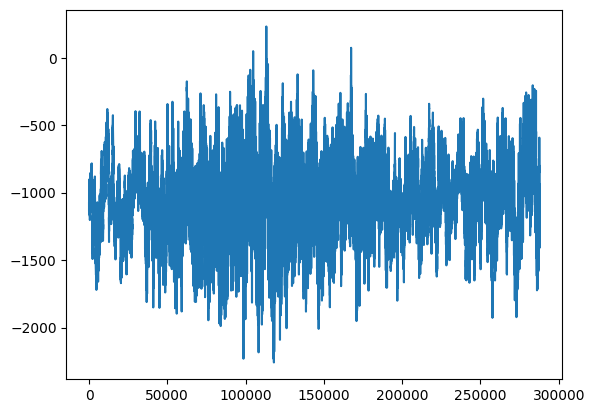

In [65]:
filename = '../data/p800-f365-a05-t03-f.wav'
samplerate, data = wavfile.read(filename)

print(data.shape)
print ("Frequency sampling:", samplerate)

plt.plot(np.take(data, 1, axis=1))
print('avg val:', np.average(np.take(data, 1, axis=1)))

Maybe there is a reason to look at the frequency domain, to see the amplitude of a given frequency...

## Plan

- One microphone was saturated, so take data from the other (that also makes the scale readable)
- There is a linear relationship between air pressure and intensity recorded by the microphone
- I think that a Fourier transform will let me look at how loud the resonant frequency was in a given recording
    - I want the resonant frequency amplitude because this is the frequency I am interested in!
- Test this for a few different values, then make a first attempt at a radial plot (I think that's the correct name...) like the one from the paper by Russel:

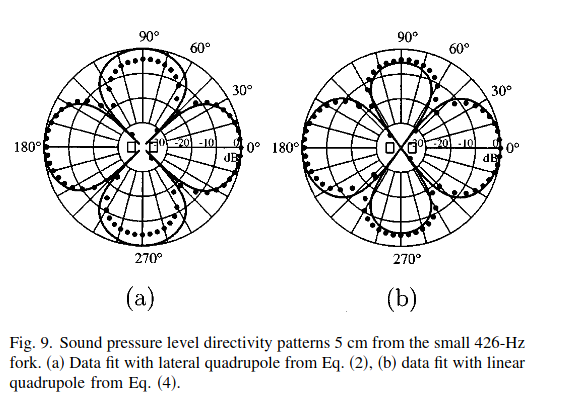

480000 1.0416666666666666e-05


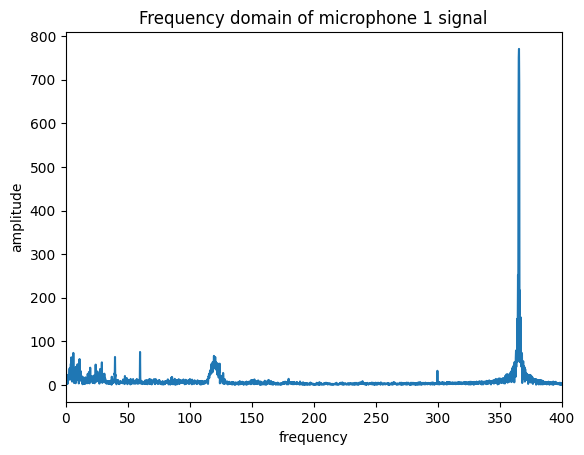

In [97]:
fdata = np.take(data, 1, axis=1)
fdata = fdata - np.average(fdata) # to get rid of the dc offset

N = len(fdata) # sample points
T = 1 / samplerate

print(N, T)

yf = np.abs(fft(fdata)[0:N//2])
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * yf)
plt.title('Frequency domain of microphone 1 signal')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim([0,400])
plt.show()


In [98]:
max_index = np.argmax(yf)
print('max_index:', max_index)
print('frequency:', xf[max_index])
print('amp. val.:', yf[max_index]/N*2)

max_index: 1828
frequency: 365.6
amp. val.: 770.6837358005951


Okay, I obviously know that it should be the resonant frequency, but it seems some dc offset is making it look like a dc frequency 0 is the main value. I guess I can try searching at greater than 10Hz (or rather 10 indicies).

EDIT: This was now fixed after I went and subtracted the average to get rid of the DC offset at the first step. I originally didn't do that, and thought of it afterwards, and just changed the code above.

In [99]:
max_index = np.argmax(yf[10:]) + 10
print('max_index:', max_index)
print('frequency:', xf[max_index])
print('amp. val.:', yf[max_index]/N*2)

max_index: 1828
frequency: 365.6
amp. val.: 770.6837358005951


I think at this point I see a clear peak at the resonant frequency and it is probably time to build the data for the radial plot.

Something like

```py
radial_data = (angle, amplitude value)
```

In [100]:
radial_data_close_field = []
radial_data_far_field = []

In [ ]:
import os

for filename in os.listdir('./data'):
    if filename.endswith('c.wave'): # close field
        pass
    elif filename.endswith('f.wav'): # far field
        pass
    else:
        pass # not a file I'm interested in